In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set the path to the data location
data_location_new = "/Users/tommieverouden/Documents/Data drive/Data/240719 New valve tests"

# Import all text files in the data location using pandas
data = {}
for file in os.listdir(data_location_new):
    if file.endswith(".txt"):
        
        # The files are comma separated and have 1 header row
        data[file] = pd.read_csv(os.path.join(data_location_new, file), sep=",", header=0)
        
# Sort the data dictionary by key
data = dict(sorted(data.items()))
        
# For 2bar_2.txt, remove the first 400 rows of data to skip a failed measurement
data["2bar_2.txt"] = data["2bar_2.txt"].iloc[400:, :]

In [3]:
# Process each measurement series
for key in data.keys():
    
    # Translate the keys: tijd = time, meetwaarde = flowrate
    data[key].columns = ["time", "flowrate"]
    
    # Remove the data that occurs before the last time the 
    # flowrate is 0
    data[key] = data[key].iloc[np.where(data[key].flowrate > 0)[0][0]:, :]
    
    # Shift the time array accordingly
    data[key].time = data[key].time - data[key].time.iloc[0]
    
    # Add a single zero back in front of the data so the shape is clearer
    data[key] = pd.concat([pd.DataFrame({"time": [0], "flowrate": [0]}), data[key]])
    
    # Reset the index
    data[key].reset_index(drop=True, inplace=True)
    
# From the filename, take the part before "bar" as the pressure,
# replace the underscore with a dot, and add it as a float to the data
for key in data.keys():
    data[key].pressure = float(key.split("bar")[0].replace("_", "."))

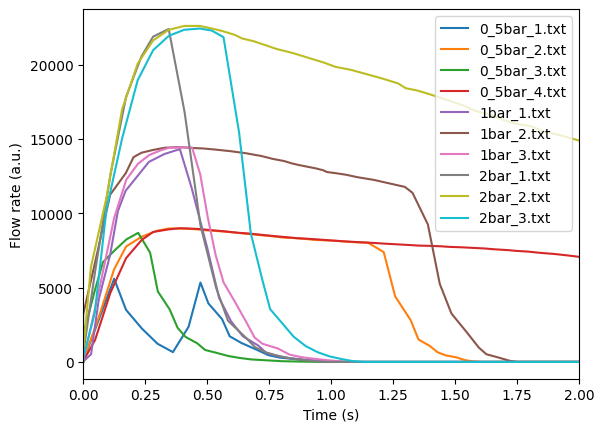

In [4]:
# Quickly plot all the data series
for key in data.keys():
    plt.plot(data[key].iloc[:,0], data[key].iloc[:,1], label=key)
    
plt.xlim([0, 2])
plt.xlabel("Time (s)")
plt.ylabel("Flow rate (a.u.)")

plt.legend()
plt.show()

# X-axis is time in seconds

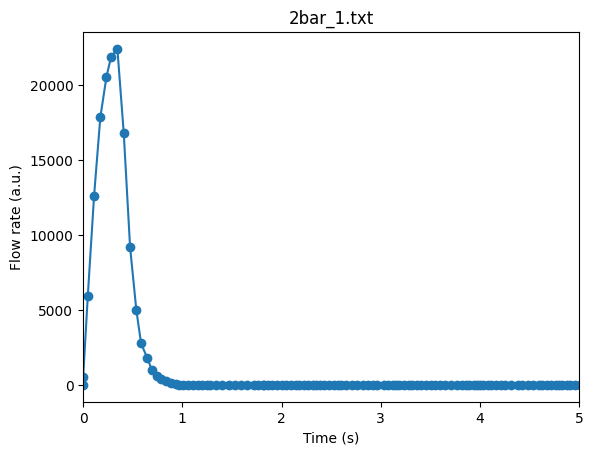

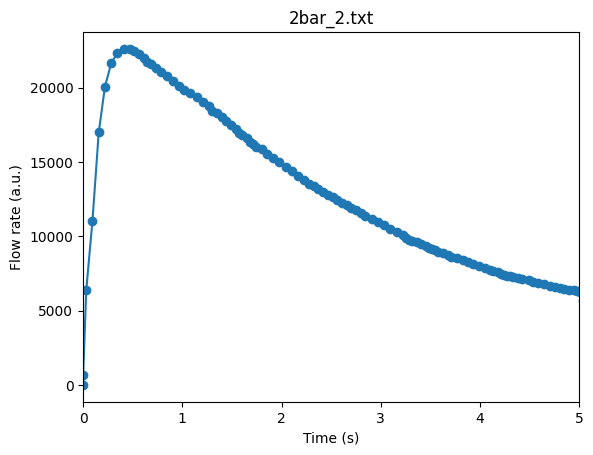

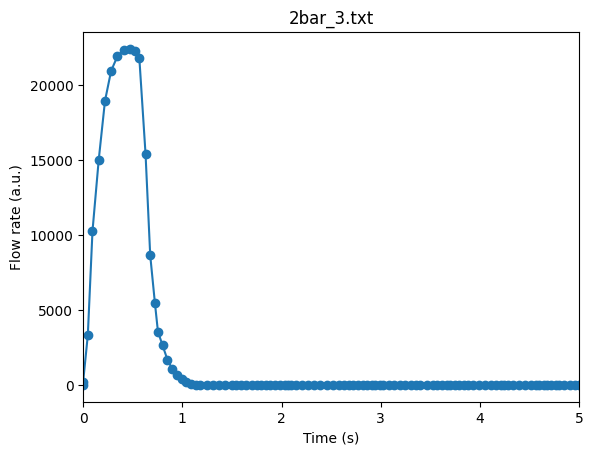

In [5]:

# Quickly plot each measurement series at 0_5 bar in a separate plot
for key in data.keys():
    if "2bar" in key:
        plt.plot(data[key].iloc[:,0], data[key].iloc[:,1], 'o-', label=key)
        plt.xlim([0, 5])
        plt.xlabel("Time (s)")
        plt.ylabel("Flow rate (a.u.)")
        plt.title(key)
        plt.show()
        

In [6]:
# Make a list of measurements that are not of interest
skip_list = ["0_5bar_1.txt", "1bar_1.txt", "2bar_1.txt"]

# Add the duration to each series
data["0_5bar_2.txt"].duration = "long burst"
data["0_5bar_3.txt"].duration = "short burst"
data["0_5bar_4.txt"].duration = "leave open"
data["1bar_2.txt"].duration = "long burst"
data["1bar_3.txt"].duration = "short burst"
data["2bar_3.txt"].duration = "short burst"
data["2bar_2.txt"].duration = "leave open"


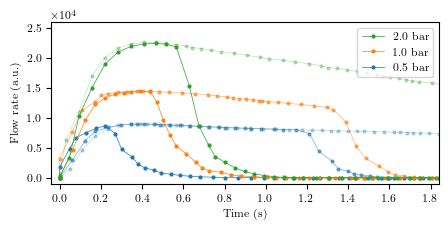

In [23]:
plt.style.use(["tex"])

# Define color and alpha mappings
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_mapping = {
    0.5: colors[0],
    1: colors[1],
    2: colors[2]
}

alpha_mapping = {
    "short burst": 1.0,
    "long burst": 0.6,
    "leave open": 0.3
}

marker_mapping = {
    "short burst": 'o',
    "long burst": 's',
    "leave open": '^'
}

fig, ax = plt.subplots(figsize=[5,2.1])

# Create a set to keep track of the pressures that have already been plotted
plotted_pressures = set()

# Plot all the data of interest, generating a label from the pressure and duration
for key in data.keys():
    if key not in skip_list:
        label = None
        if data[key].pressure not in plotted_pressures and data[key].duration == "short burst":
            label = str(data[key].pressure) + " bar"
            plotted_pressures.add(data[key].pressure)
        plt.plot(data[key].iloc[:,0], data[key].iloc[:,1], 'o-', markersize=2,
                 label=label,
                 color=color_mapping[data[key].pressure],
                 alpha=alpha_mapping[data[key].duration],
                 linewidth=0.5)

# Finish plot
plt.xticks(np.arange(0, 2.2, .2))
plt.xlim([-0.04, 1.84])
plt.xlabel("Time (s)")
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim([-0.1e4, 2.6e4])
plt.ylabel("Flow rate (a.u.)")

# Get the current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reverse the handles and labels and set the legend
handles = handles[::-1]
labels = labels[::-1]
plt.legend(handles, labels)
plt.show()

# Save the plot to the plots folder
fig.savefig('plots/new_valve.pdf', format='pdf', bbox_inches='tight')